In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataset_builder as db

In [59]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
}

In [60]:
import tensorflow as tf 
import keras 
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from collections import Counter

from keras import regularizers
from keras.layers import Reshape
from keras.models import Sequential, Model, load_model, model_from_json 
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Reshape, Concatenate,  Dropout 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers.activation.leaky_relu import LeakyReLU
from scipy.signal import resample
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

# ORIGINAL

In [61]:
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["rotationRate","userAcceleration"]
mode = "mag"
cga = True # Add gravity to acceleration or not
print("[INFO] -- Selected sensor data types: "+str(sdt)+" -- Mode: "+str(mode)+" -- Grav+Acc: "+str(cga))    

act_labels = ACT_LABELS [0:5]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = db.set_data_types(sdt)
dataset = db.creat_time_series(dt_list, act_labels, trial_codes, mode=mode, labeled=True, combine_grav_acc = cga)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    

test_trail = [11,12,13,14,15,16]  
print("[INFO] -- Test Trials: "+str(test_trail))
test_ts = dataset.loc[(dataset['trial'].isin(test_trail))]
train_ts = dataset.loc[~(dataset['trial'].isin(test_trail))]
    
print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(test_ts.shape))

[INFO] -- Selected sensor data types: ['rotationRate', 'userAcceleration'] -- Mode: mag -- Grav+Acc: True
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1074087, 9)
[INFO] -- Test Trials: [11, 12, 13, 14, 15, 16]
[INFO] -- Shape of Train Time-Series :(846789, 9)
[INFO] -- Shape of Test Time-Series :(227298, 9)


In [62]:
## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
s = 10
train_data, act_train, id_train, train_mean, train_std = db.ts_to_secs(train_ts.copy(),
                                                                   w,
                                                                   s,
                                                                   standardize = True)

s = 10
test_data, act_test, id_test, test_mean, test_std = db.ts_to_secs(test_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)


## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
train_data = np.expand_dims(train_data,axis=3)
print("[INFO] -- Shape of Training Sections:", train_data.shape)
test_data = np.expand_dims(test_data,axis=3)
print("[INFO] -- Shape of Test Sections:", test_data.shape)

act_train_labels = to_categorical(act_train)
act_test_labels = to_categorical(act_test)
id_train_labels = to_categorical(id_train)
id_test_labels = to_categorical(id_test)

[INFO] -- Training Data has been standardized: the mean is = [1.65126541 1.14737672] ; and the std is = [1.53328895 0.60708026]
[INFO] -- Test Data has been standardized
[INFO] -- Shape of Training Sections: (82235, 2, 128, 1)
[INFO] -- Shape of Test Sections: (21210, 2, 128, 1)


In [63]:
#https://stackoverflow.com/a/45305384/5210098
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
class Estimator:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm, hid_act_func="relu"):
        # Start
        x = Conv2D(64, fm, padding="same", kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(inp)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(64, fm, padding="same", kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)

        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm, act_func="softmax", hid_act_func="relu", b_name="Identifier"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(inp)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # End
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(16, kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func, name = b_name)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm, act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Estimator.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Estimator.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model

In [65]:
def print_results(M, X, Y):
    result1 = M.evaluate(X, Y, verbose = 2)
    act_acc = round(result1[1], 4)*100
    print("***[RESULT]*** ACT Accuracy: "+str(act_acc))

    preds = M.predict(X)
    preds = np.argmax(preds, axis=1)
    conf_mat = confusion_matrix(np.argmax(Y, axis=1), preds)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    print("***[RESULT]*** ACT  Confusion Matrix")
    print(" | ".join(act_labels))
    print(np.array(conf_mat).round(3)*100)  

    f1act = f1_score(np.argmax(Y, axis=1), preds, average=None).mean()
    print("***[RESULT]*** ACT Averaged F-1 Score : "+str(f1act*100))
    
def eval_act(X,Y, act_class_numbers = 5, fm = (2,5), ep=100):
    height = X.shape[1]
    width = X.shape[2]
    ## Callbacks
    eval_metric= "val_acc"    
    early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'max', patience = 20)
    filepath="HAR_Comb.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='max')
    callbacks_list = [early_stop,checkpoint]
    
    eval_act = Estimator.build(height, width, act_class_numbers, name ="EVAL_ACT", fm=fm, act_func="softmax",hid_act_func="relu")
    eval_act.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])
    X , Y = shuffle(X,Y)
    eval_act.fit(X, Y,
                validation_split = .1,
                epochs = ep,
                batch_size = 128,
                verbose = 0,
                class_weight = get_class_weights(np.argmax(Y,axis=1)),
                callbacks = callbacks_list
               )

    eval_act.load_weights("HAR_Comb.hdf5")
    eval_act.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])
    
    print_results(eval_act, X, Y)

In [66]:
print("Training:")
eval_act(train_data, act_train_labels)

Training:
2570/2570 - 16s - loss: 0.1662 - acc: 0.9972 - 16s/epoch - 6ms/step
***[RESULT]*** ACT Accuracy: 99.72
2570/2570 [==============================] - 16s 6ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[99.6  0.1  0.2  0.   0. ]
 [ 0.2 99.4  0.3  0.1  0. ]
 [ 0.1  0.1 99.8  0.   0. ]
 [ 0.   0.   0.2 99.8  0. ]
 [ 0.   0.   0.1  0.  99.9]]
***[RESULT]*** ACT Averaged F-1 Score : 99.6800342853769


In [142]:
print("Inference:")
from keras.models import load_model
eval_act = load_model("HAR_Comb.hdf5")
X = test_data
Y = act_test_labels
print_results(eval_act, X, Y)

Inference:
663/663 - 5s - loss: 0.1818 - acc: 0.9917 - 5s/epoch - 7ms/step
***[RESULT]*** ACT Accuracy: 99.17
663/663 [==============================] - 5s 7ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[97.8  1.8  0.3  0.   0. ]
 [ 2.9 96.4  0.3  0.4  0. ]
 [ 0.1  0.  99.9  0.   0. ]
 [ 0.7  0.3  0.  99.   0. ]
 [ 0.   0.   0.1  0.  99.9]]
***[RESULT]*** ACT Averaged F-1 Score : 98.54299026848027


# REPLACEMENT 

In [143]:
w_train_data = train_data[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]
b_train_data = train_data[act_train == 3.]
g_train_data = train_data[act_train == 4.]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data.shape))

w_test_data = test_data[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]
b_test_data = test_data[act_test == 3.]
g_test_data = test_data[act_test == 4.]

print("[INFO] -- Shape of Train Grays :"+str(g_test_data.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_test_data.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_test_data.shape))

[INFO] -- Shape of Train Grays :(22176, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(10129, 2, 128, 1)
[INFO] -- Shape of Train Whites :(49930, 2, 128, 1)
[INFO] -- Shape of Train Grays :(7857, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(2686, 2, 128, 1)
[INFO] -- Shape of Train Whites :(10667, 2, 128, 1)


In [69]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train = np.random.choice(g_train_data.shape[0], b_train_data.shape[0], replace=False)
tmp =  g_train_data[rnd_idx_train,:]
b_train_transformed = tmp.copy()

x_train = np.append(w_train_data, g_train_data, axis=0)
x_train = np.append(x_train, b_train_data, axis=0)

x_train_transformed = np.append(w_train_data, g_train_data, axis=0)
x_train_transformed = np.append(x_train_transformed , b_train_transformed, axis=0)

resh = np.prod(w_train_data.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data.shape[1], w_train_data.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh,))(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data.shape[1], w_train_data.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet = Model(inp, out)

print(raet.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet.compile(optimizer='adam', loss='mse')

x_train, x_train_transformed = shuffle(x_train, x_train_transformed)

raet.fit(x_train , x_train_transformed,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 2, 128, 64)        384       
                                                                 
 conv2d_70 (Conv2D)          (None, 2, 128, 32)        10272     
                                                                 
 conv2d_71 (Conv2D)          (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_55 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_2 (Reshape)         (None, 256)               0         
                                                           

In [144]:
rae = load_model("rae_best.hdf5")

rep_x_test = test_data.copy()
rep_x_test = rae.predict(rep_x_test, verbose=1)

from keras.models import load_model
eval_act = load_model("HAR_Comb.hdf5")
X = rep_x_test
Y = act_test_labels
print_results(eval_act, X, Y)

663/663 [==============================] - 6s 9ms/step
663/663 - 5s - loss: 1.4804 - acc: 0.8520 - 5s/epoch - 7ms/step
***[RESULT]*** ACT Accuracy: 85.2
663/663 [==============================] - 5s 7ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[90.1  9.7  0.2  0.   0. ]
 [ 0.3 99.5  0.1  0.   0. ]
 [ 2.   2.3 95.6  0.   0. ]
 [ 4.4  3.6  0.4  1.3 90.3]
 [ 0.   0.   0.1  0.  99.9]]
***[RESULT]*** ACT Averaged F-1 Score : 73.46712773011272


In [145]:
def plot_signals(rnd_smpl, pts, org, tra):
    plt.rcParams['figure.figsize'] = (60,30)
    plt.rcParams['font.size'] = 40
    plt.rcParams['image.cmap'] = 'plasma'
    plt.rcParams['axes.linewidth'] = 2

    dt = ["rotRaw","rotTra","acclRaw","acclTra"]
    clr = ["rp-", "gs-", "bo-", "k*-", "c.-"]   
    lbl = ["DWS", "UPS","WLK", "JOG", "STD"]


    fig, ax = plt.subplots(4, 5, sharex=True, sharey=True)
    for k in range(5):
        raw_rot = org[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0]   
        tra_rot = tra[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0]
        raw_accl = org[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0]   
        tra_accl =tra[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0]
        ax[0,k].plot(np.arange(0.,128./50.,1./50), raw_rot, clr[k], linewidth=5, markersize=5)
        ax[1,k].plot(np.arange(0.,128./50.,1./50), tra_rot, clr[k], linewidth=5, markersize=5)
        ax[2,k].plot(np.arange(0.,128./50.,1./50), raw_accl, clr[k], linewidth=5, markersize=5)
        ax[3,k].plot(np.arange(0.,128./50.,1./50), tra_accl, clr[k], linewidth=5, markersize=5)    
        ax[0,k].set_title(lbl[k])
        if k < 4:
            ax[k,0].set_ylabel(dt[k])


    #plt.setp(ax, yticks=np.arange(-2, 6, 2))
    fig.text(0.5, 0.04, 'second', ha='center')
    #fig.text(0.04, 0.5, 'magnitude value', va='center', rotation='vertical', fontsize=26)
    # ax[0].legend(loc="upper center", fontsize=26)


Random Test Sample: #48


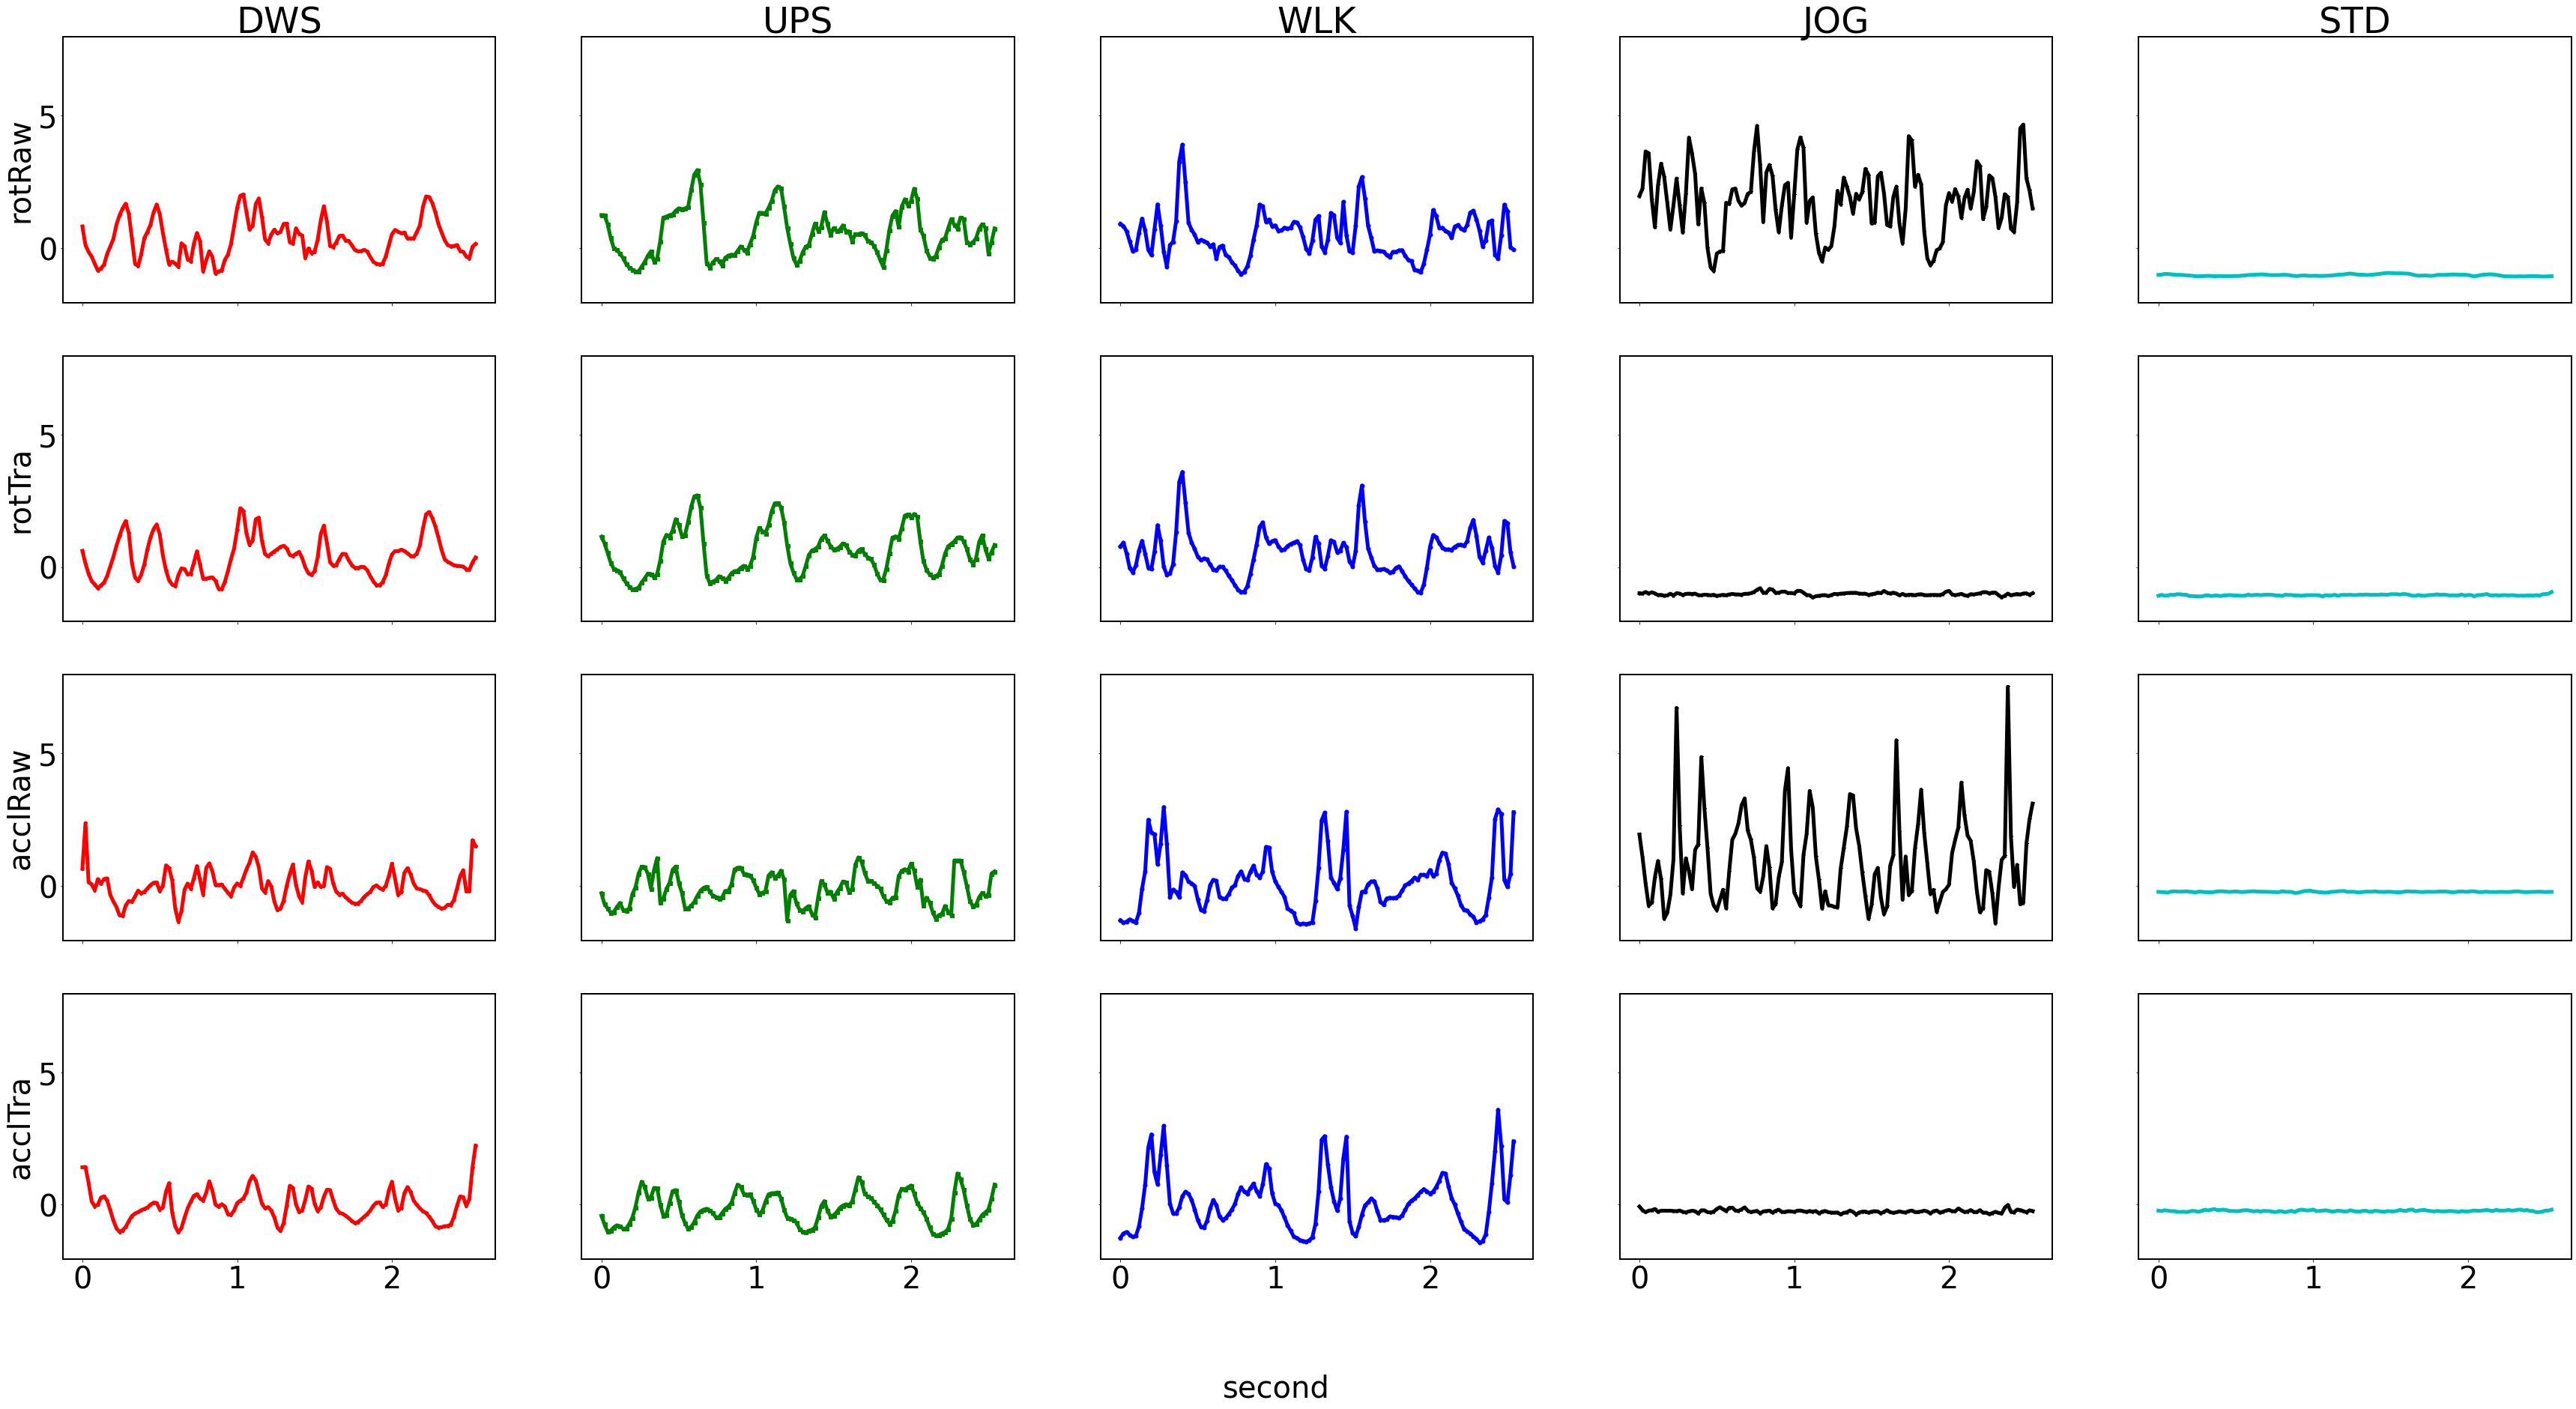

In [146]:
rnd_smpl= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl))
plot_signals(rnd_smpl, pts, test_data, rep_x_test)

# ANONYMIZATION

In [147]:
data_subject_info = pd.read_csv("data_subjects_info.csv")
id_gen_info = data_subject_info[["code","gender"]].values
gen_id_dic = {item[0]:item[1] for item in id_gen_info}

tmp = id_train.copy()
gen_train = np.array([gen_id_dic[item+1] for item in tmp])
gen_train_labels = (gen_train).copy()

tmp = id_test.copy()
gen_test = np.array([gen_id_dic[item+1] for item in tmp])
gen_test_labels = (gen_test).copy()

[gen_train_labels.shape, gen_test_labels.shape]

[(82235,), (21210,)]

In [148]:
w_train_data = train_data[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]
w_act_train_labels = act_train_labels[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]
w_gen_train_labels = gen_train_labels[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]

w_test_data = test_data[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]
w_act_test_labels = act_test_labels[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]
w_gen_test_labels = gen_test_labels[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]

In [149]:
def eval_gen(X,Y, gen_class_numbers = 1, fm = (2,5), ep=100):
    height = X.shape[1]
    width = X.shape[2]
    ## Callbacks
    eval_metric= "val_acc"    
    early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'max', patience = 15)
    filepath="GR.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=2, save_best_only=True, mode='max')
    callbacks_list = [early_stop,checkpoint]
    
    eval_gen = Estimator.build(height, width, gen_class_numbers, name ="EVAL_GEN", fm=fm, act_func="sigmoid",hid_act_func="relu")
    eval_gen.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
#     X , Y = shuffle(X,Y)
#     eval_gen.fit(X, Y,
#                 validation_split = .2,
#                 epochs = ep,
#                 batch_size = 128,
#                 verbose = 0,
#                 class_weight = get_class_weights(Y),
#                 callbacks = callbacks_list
#                )

    eval_gen.load_weights("GR.hdf5")
    eval_gen.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])

    result1 = eval_gen.evaluate(X, Y, verbose = 2)
    act_acc = round(result1[1],4)*100
    print("***[RESULT]***GEN Accuracy: "+str(act_acc))

In [150]:
print("Training:")
eval_gen(w_train_data, w_gen_train_labels)

Training:
1561/1561 - 11s - loss: 0.1005 - acc: 0.9951 - 11s/epoch - 7ms/step
***[RESULT]***GEN Accuracy: 99.51


In [151]:
print("Inferecne:")
eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(w_test_data, w_gen_test_labels, verbose = 1)
act_acc = round(result1[1],4)*100
print("***[RESULT]***Original: GEN Test Accuracy: "+str(act_acc))

Inferecne:
334/334 [==============================] - 3s 8ms/step - loss: 0.1405 - acc: 0.9830
***[RESULT]***Original: GEN Test Accuracy: 98.3


In [152]:
w_data_train_rep = w_train_data.copy()
w_data_train_rep = rae.predict(w_data_train_rep, verbose=1)
w_data_test_rep = w_test_data.copy()
w_data_test_rep = rae.predict(w_data_test_rep, verbose=1)

334/334 [==============================] - 3s 9ms/step


In [96]:
print("Inferecne:")
eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(w_data_test_rep, w_gen_test_labels, verbose = 2)
act_acc = round(result1[1],4)*100
print("***[RESULT]***Replaced: GEN Test Accuracy: "+str(act_acc))

Inferecne:
334/334 - 2s - loss: 0.1500 - acc: 0.9792 - 2s/epoch - 7ms/step
***[RESULT]***Replaced: GEN Test Accuracy: 97.92


In [97]:
class Enc_Reg:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm, hid_act_func="relu"):
        # Start
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)

        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm, act_func="softmax", hid_act_func="relu"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # End
        x = Flatten()(x)
        x = Dense(64, kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(16, kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm, act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Enc_Reg.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Enc_Reg.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model


class Dec_Reg:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm, hid_act_func="relu"):
        # Start
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)


        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm = (1,3), act_func="softmax", hid_act_func="relu"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 3
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        #4
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        
        # End
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(32, kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm, act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Dec_Reg.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Dec_Reg.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model


class Encoder:
    l2p = 0.001
    @staticmethod
    def layers(x, fm, act_func="linear", hid_act_func="relu"):
        x = Conv2D(64, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(64, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(64, fm, activation=hid_act_func,kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(1, fm, activation=act_func, padding='same')(x) 
        y = BatchNormalization()(x)

        return y
   
    @staticmethod
    def build(height, width, fm, act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        enc = Encoder.layers(inp, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=enc ,name="Encoder")
        return model

class Decoder:
    l2p = 0.001
    @staticmethod
    def layers(y, height, width, fm, act_func="linear", hid_act_func="relu"):
        
        x = Conv2DTranspose(64, fm, strides = (1, 1), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(y)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(64, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(64, fm, strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        
        xh = Conv2D(1, fm, activation=act_func, padding='same')(x)
        return xh
   
    @staticmethod
    def build(height, width, fm , act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        dec  = Decoder.layers(inp,height, width, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=dec ,name="Decoder")
        return model        

In [98]:
height = w_data_train_rep.shape[1]
width = w_data_train_rep.shape[2]
fm = (2,5)

In [133]:
rw_act_labels = np.delete(w_act_train_labels,[3,4], axis=1)
rw_act_labels.shape

(49930, 3)

In [134]:
def build_AAE(loss_weights):
    id_class_numbers = 1
    act_class_numbers = 3
    #fm = (2,3)
    #reps_id = Enc_Reg.build(height, width//4, id_class_numbers, name ="EncReg", fm=fm, act_func="sigmoid",hid_act_func="relu")
    fm = (2,5)
    rcon_id = Dec_Reg.build(height, width, id_class_numbers, name ="DecReg", fm=fm, act_func="sigmoid",hid_act_func="relu")
    rcon_task = Dec_Reg.build(height, width, act_class_numbers, name ="ActReg", fm=fm, act_func="softmax",hid_act_func="relu")

    #reps_id.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
    rcon_id.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
    rcon_task.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])

    #reps_id.trainable = False
    rcon_id.trainable = False
    rcon_task.trainable = False

    enc_to_reps = Encoder.build(height, width, fm, act_func="linear", hid_act_func="relu")
    reps_to_dec = Decoder.build(height, width//4, fm, act_func="linear", hid_act_func="relu")
    enc_to_reps.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
    reps_to_dec.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])

    x = Input(shape=(height, width,1))
    z = enc_to_reps(x)
    #idz = reps_id(z)
    xh = reps_to_dec(z)
    idxh = rcon_id(xh)
    txh = rcon_task(xh)



    anon_model = Model(inputs = x,
                       outputs = [xh,
                                  #idz,
                                  idxh,
                                  txh
                                 ],
                       name ="anon") 
    anon_model.compile(loss = ["mean_squared_error",
                               #"binary_crossentropy",
                                "binary_crossentropy",
                               "categorical_crossentropy"
                              ],
                       loss_weights = loss_weights,                 
                       optimizer = "adam",
                       metrics = ["acc"])
    #enc_to_reps.set_weights(enc_dec_tmp.layers[1].get_weights()) 
    #reps_to_dec.set_weights(enc_dec_tmp.layers[2].get_weights()) 

    iterations = 1
    batch_size = 128

    ep1 = 50
    ep2 = 50
    ep3 = 50
    ep4 = 100

    return anon_model

In [135]:
eq_w_gen_labels = w_gen_train_labels.copy().astype(float)
eq_w_gen_labels.fill(0.5)

In [136]:
loss_weights=[1, 1, 2]            
anon_model = build_AAE(loss_weights)
anon_model.summary()

Model: "anon"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_129 (InputLayer)         [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 Encoder (Functional)           (None, 2, 32, 1)     84165       ['input_129[0][0]']              
                                                                                                  
 Decoder (Functional)           (None, 2, 128, 1)    84161       ['Encoder[0][0]']                
                                                                                                  
 DecReg (Functional)            (None, 1)            78497       ['Decoder[0][0]']                
                                                                                               

In [132]:
for itr in range(0,iterations):

    print("______________________________________")
    print("[INFO] --  Epoch: "+str(itr))

    if itr == 0:
        print("--> Initialize...")
        a_data_nsh = w_data_train_rep.copy()
    
    a_data, a_data_org, id_a_data, act_a_data = shuffle(a_data_nsh, w_data_train_rep.copy(), w_gen_train_labels, rw_act_labels) 
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', mode = 'max', patience=10, restore_best_weights=True)
    print("______________________________________")
    rcon_id.fit(a_data, id_a_data,
                        validation_split = .2,
                           epochs = ep2,
                           batch_size = batch_size,
                           class_weight = get_class_weights(id_a_data),   
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    rcon_task.fit(a_data, act_a_data,
                        validation_split = .2,
                           epochs = ep3,
                           batch_size = batch_size,
                           class_weight = get_class_weights(np.argmax(act_a_data,axis=1)),       
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    print("[INFO] --  (D) anon: "+str(itr))    
    early_stop_anon = keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=15, restore_best_weights=True)

    
    anon_model.fit(a_data, [a_data_org,
                            #eq_w_gen_labels,
                            eq_w_gen_labels,
                            act_a_data],
                   validation_split = .1,
                   epochs = ep4,
                   batch_size = 128,
                   verbose = 0,
                   callbacks = [early_stop_anon]
                  )
    
    z_data_nsh = anon_model.layers[1].predict(w_data_train_rep, verbose = 1)    
    a_data_nsh = anon_model.predict(w_data_train_rep, verbose = 1)[0]
    
    anon_model.save("gen_anon_112_"+str(itr)+".hdf5")
    print("[INFO] --  Saved model to disk: itr "+str(itr))

Model: "anon"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_124 (InputLayer)         [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 Encoder (Functional)           (None, 2, 32, 1)     84165       ['input_124[0][0]']              
                                                                                                  
 Decoder (Functional)           (None, 2, 128, 1)    84161       ['Encoder[0][0]']                
                                                                                                  
 DecReg (Functional)            (None, 1)            78497       ['Decoder[0][0]']                
                                                                                               

KeyboardInterrupt: 

In [137]:
itr = 0
anon_model_l = load_model("gen_anon_112_"+str(itr)+".hdf5")
rep_anon_test = anon_model_l.predict(rep_x_test, verbose = 1)[0]

X = rep_anon_test
Y = act_test_labels

print_results(eval_act, X, Y)

eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(rep_anon_test, gen_test_labels, verbose = 2)
act_acc = round(result1[1],4)*100
print("***[RESULT]***GEN Test Accuracy: "+str(act_acc))

663/663 [==============================] - 16s 23ms/step
663/663 - 4s - loss: 1.2113 - acc: 0.8370 - 4s/epoch - 7ms/step
***[RESULT]*** ACT Accuracy: 83.7
663/663 [==============================] - 5s 7ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[83.5 14.3  2.1  0.1  0. ]
 [ 0.8 97.   2.2  0.   0. ]
 [ 3.4  2.1 94.5  0.   0. ]
 [ 2.5  3.1  2.9  0.1 91.4]
 [ 0.   0.   0.4  0.  99.6]]
***[RESULT]*** ACT Averaged F-1 Score : 71.08952054943852
663/663 - 5s - loss: 1.6635 - acc: 0.3927 - 5s/epoch - 7ms/step
***[RESULT]***GEN Test Accuracy: 39.269999999999996


Random Test Sample: #77


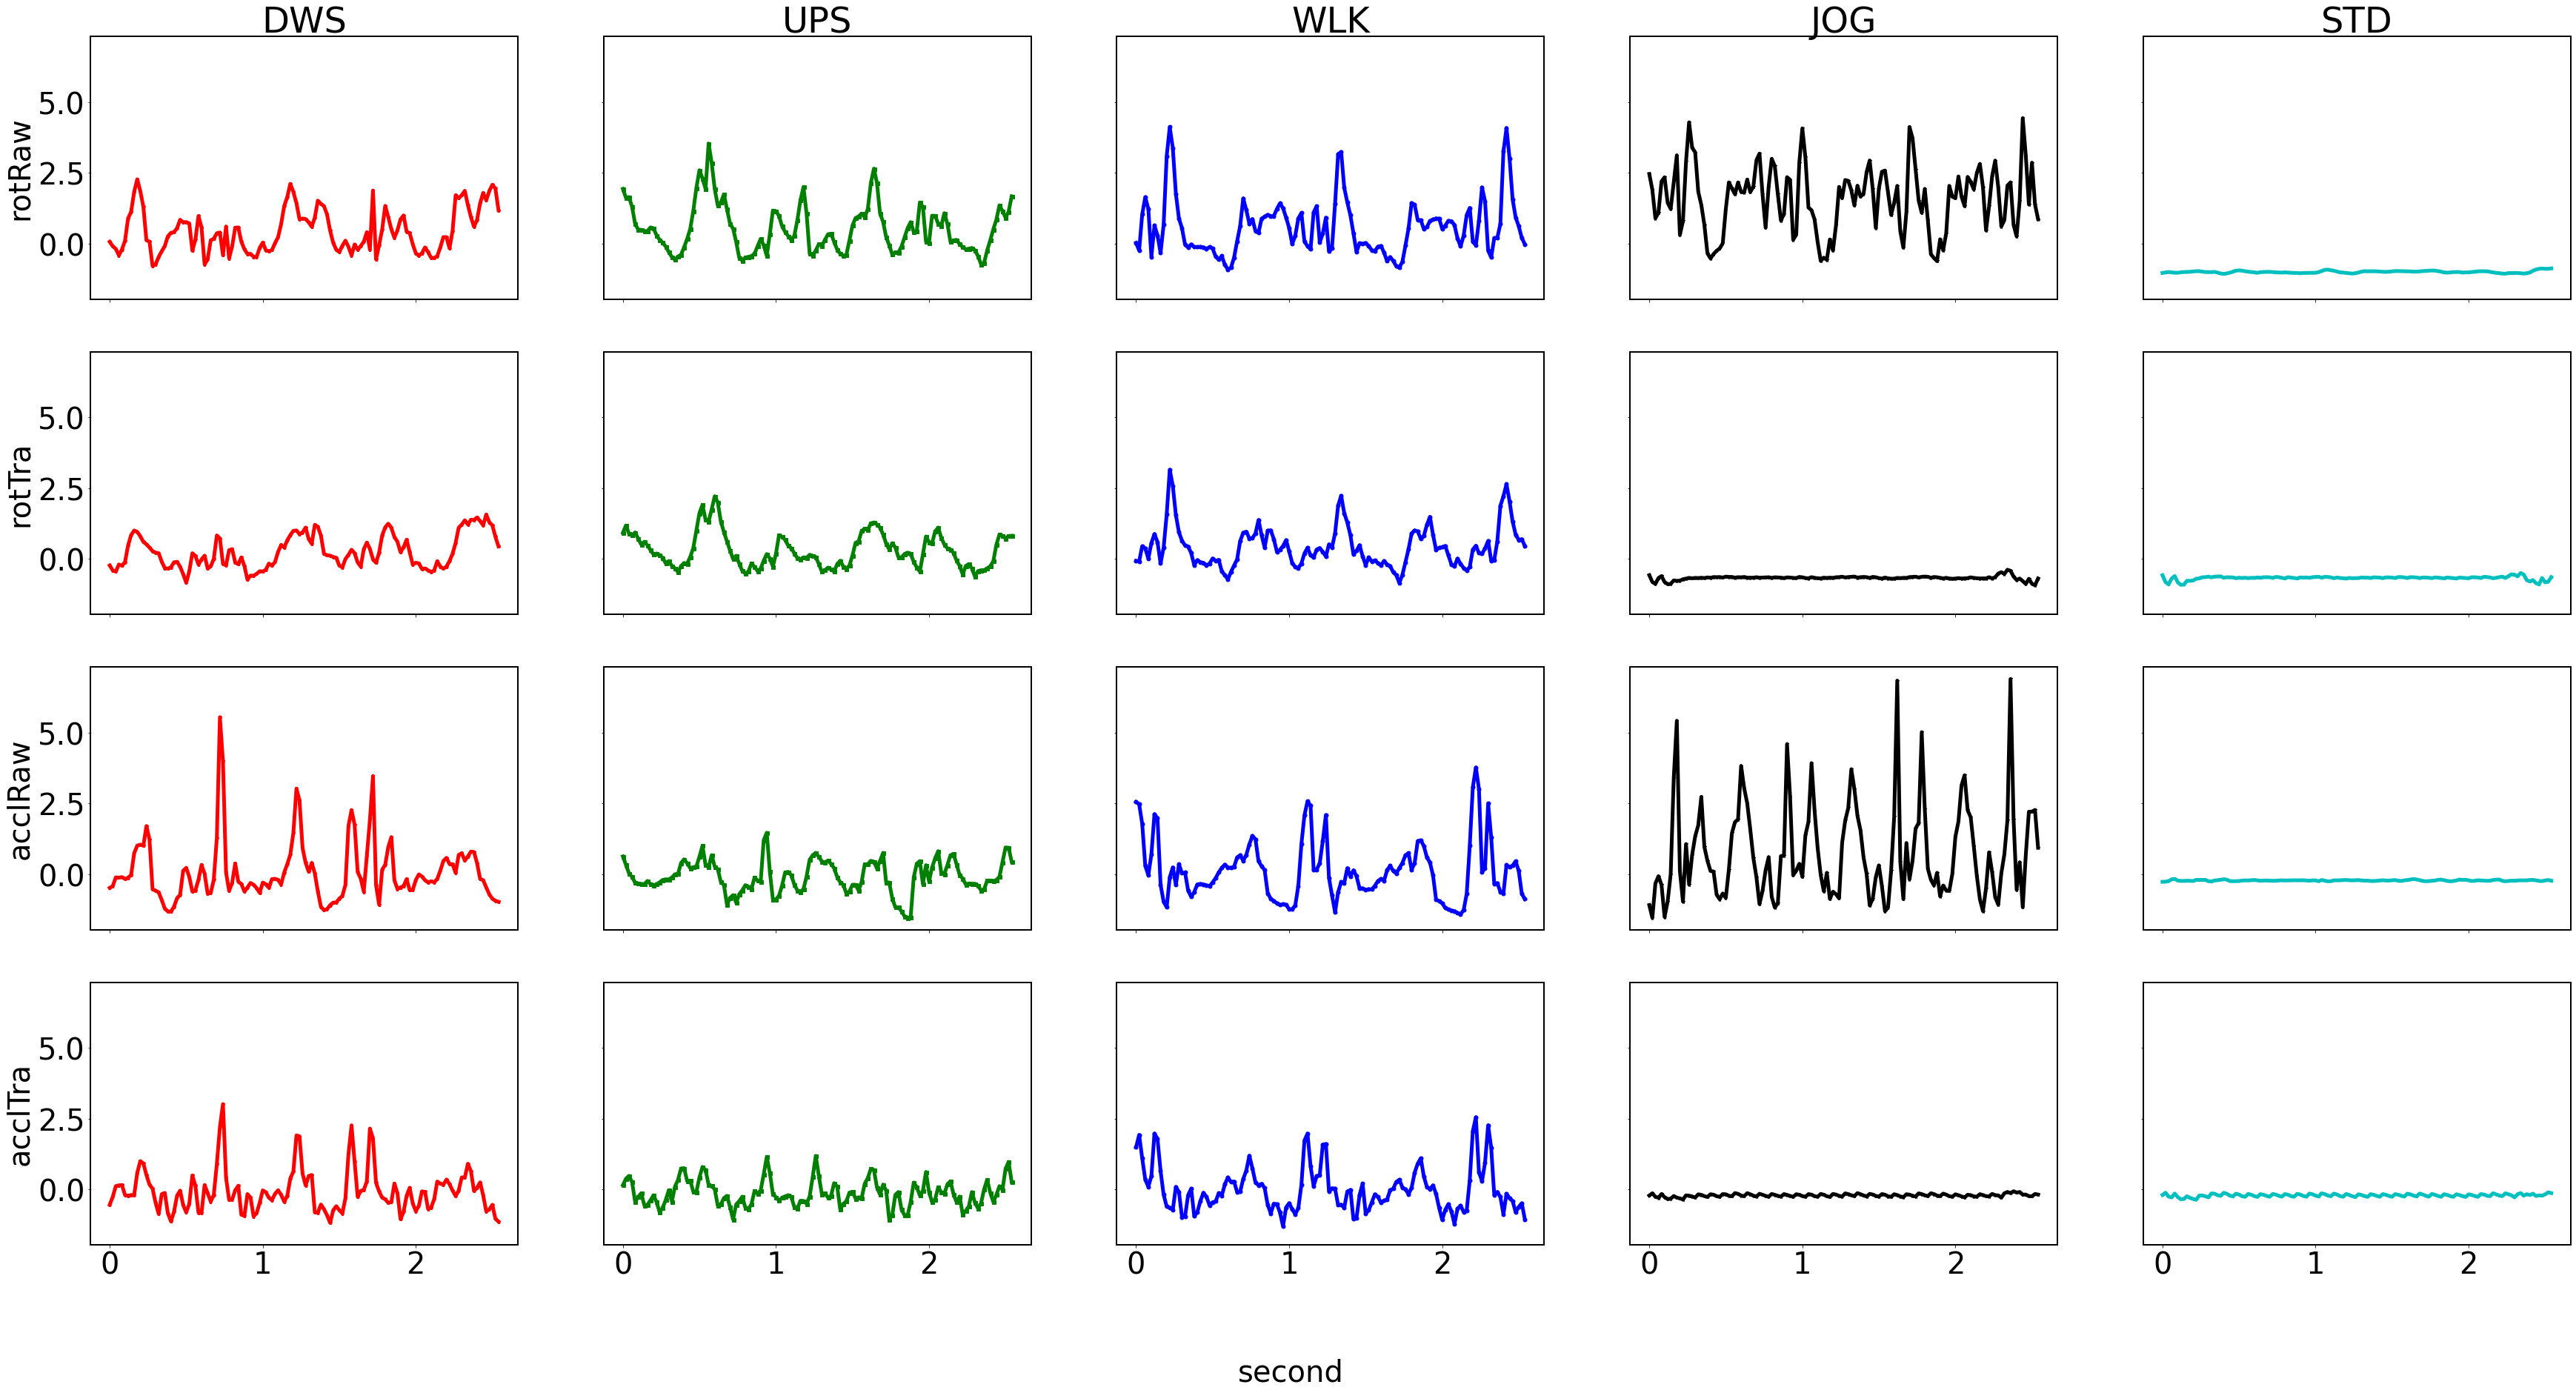

In [138]:
#rnd_smpl= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl))
plot_signals(rnd_smpl, pts, test_data, rep_anon_test)

In [139]:
loss_weights=[1, 1, 1]            
anon_model = build_AAE(loss_weights)
anon_model.summary()

Model: "anon"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_134 (InputLayer)         [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 Encoder (Functional)           (None, 2, 32, 1)     84165       ['input_134[0][0]']              
                                                                                                  
 Decoder (Functional)           (None, 2, 128, 1)    84161       ['Encoder[0][0]']                
                                                                                                  
 DecReg (Functional)            (None, 1)            78497       ['Decoder[0][0]']                
                                                                                               

In [ ]:
for itr in range(0,iterations):

    
    print("______________________________________")
    print("[INFO] --  Epoch: "+str(itr))

    if itr == 0:
        print("--> Initialize...")
        a_data_nsh = w_data_train_rep.copy()
    
    a_data, a_data_org, id_a_data, act_a_data = shuffle(a_data_nsh, w_data_train_rep.copy(), w_gen_train_labels, rw_act_labels) 
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', mode = 'max', patience=10, restore_best_weights=True)
    print("______________________________________")
    rcon_id.fit(a_data, id_a_data,
                        validation_split = .2,
                           epochs = 50,
                           batch_size = batch_size,
                           class_weight = get_class_weights(id_a_data),   
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    rcon_task.fit(a_data, act_a_data,
                        validation_split = .2,
                           epochs = 50,
                           batch_size = batch_size,
                           class_weight = get_class_weights(np.argmax(act_a_data,axis=1)),       
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    print("[INFO] --  (D) anon: "+str(itr))    
    early_stop_anon = keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=15, restore_best_weights=True)

    
    anon_model.fit(a_data, [a_data_org,
                            #eq_w_gen_labels,
                            eq_w_gen_labels,
                            act_a_data],
                   validation_split = .1,
                   epochs = 100,
                   batch_size = 128,
                   verbose = 0,
                   callbacks = [early_stop_anon]
                  )
    
    z_data_nsh = anon_model.layers[1].predict(w_data_train_rep, verbose = 1)    
    a_data_nsh = anon_model.predict(w_data_train_rep, verbose = 1)[0]
    
    anon_model.save("gen_anon_111_"+str(itr)+".hdf5")
    print("[INFO] --  Saved model to disk: itr "+str(itr))

______________________________________
[INFO] --  Epoch: 0
--> Initialize...
______________________________________


NameError: name 'rcon_id' is not defined

In [140]:
itr = 0
anon_model_l = load_model("gen_anon_111_"+str(itr)+".hdf5")
rep_anon_test = anon_model_l.predict(rep_x_test, verbose = 1)[0]

X = rep_anon_test
Y = act_test_labels

print_results(eval_act, X, Y)

eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(rep_anon_test, gen_test_labels, verbose = 2)
act_acc = round(result1[1],4)*100
print("***[RESULT]***GEN Test Accuracy: "+str(act_acc))

663/663 [==============================] - 15s 22ms/step
663/663 - 5s - loss: 1.3839 - acc: 0.8499 - 5s/epoch - 7ms/step
***[RESULT]*** ACT Accuracy: 84.99
663/663 [==============================] - 5s 7ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[93.   4.2  2.7  0.1  0. ]
 [ 2.2 94.9  2.9  0.   0. ]
 [ 2.1  1.  96.8  0.   0. ]
 [ 3.5  3.7  1.4  0.  91.4]
 [ 0.   0.1  0.3  0.  99.5]]
***[RESULT]*** ACT Averaged F-1 Score : 73.06338823224509
663/663 - 5s - loss: 1.6461 - acc: 0.4511 - 5s/epoch - 7ms/step
***[RESULT]***GEN Test Accuracy: 45.11


Random Test Sample: #77


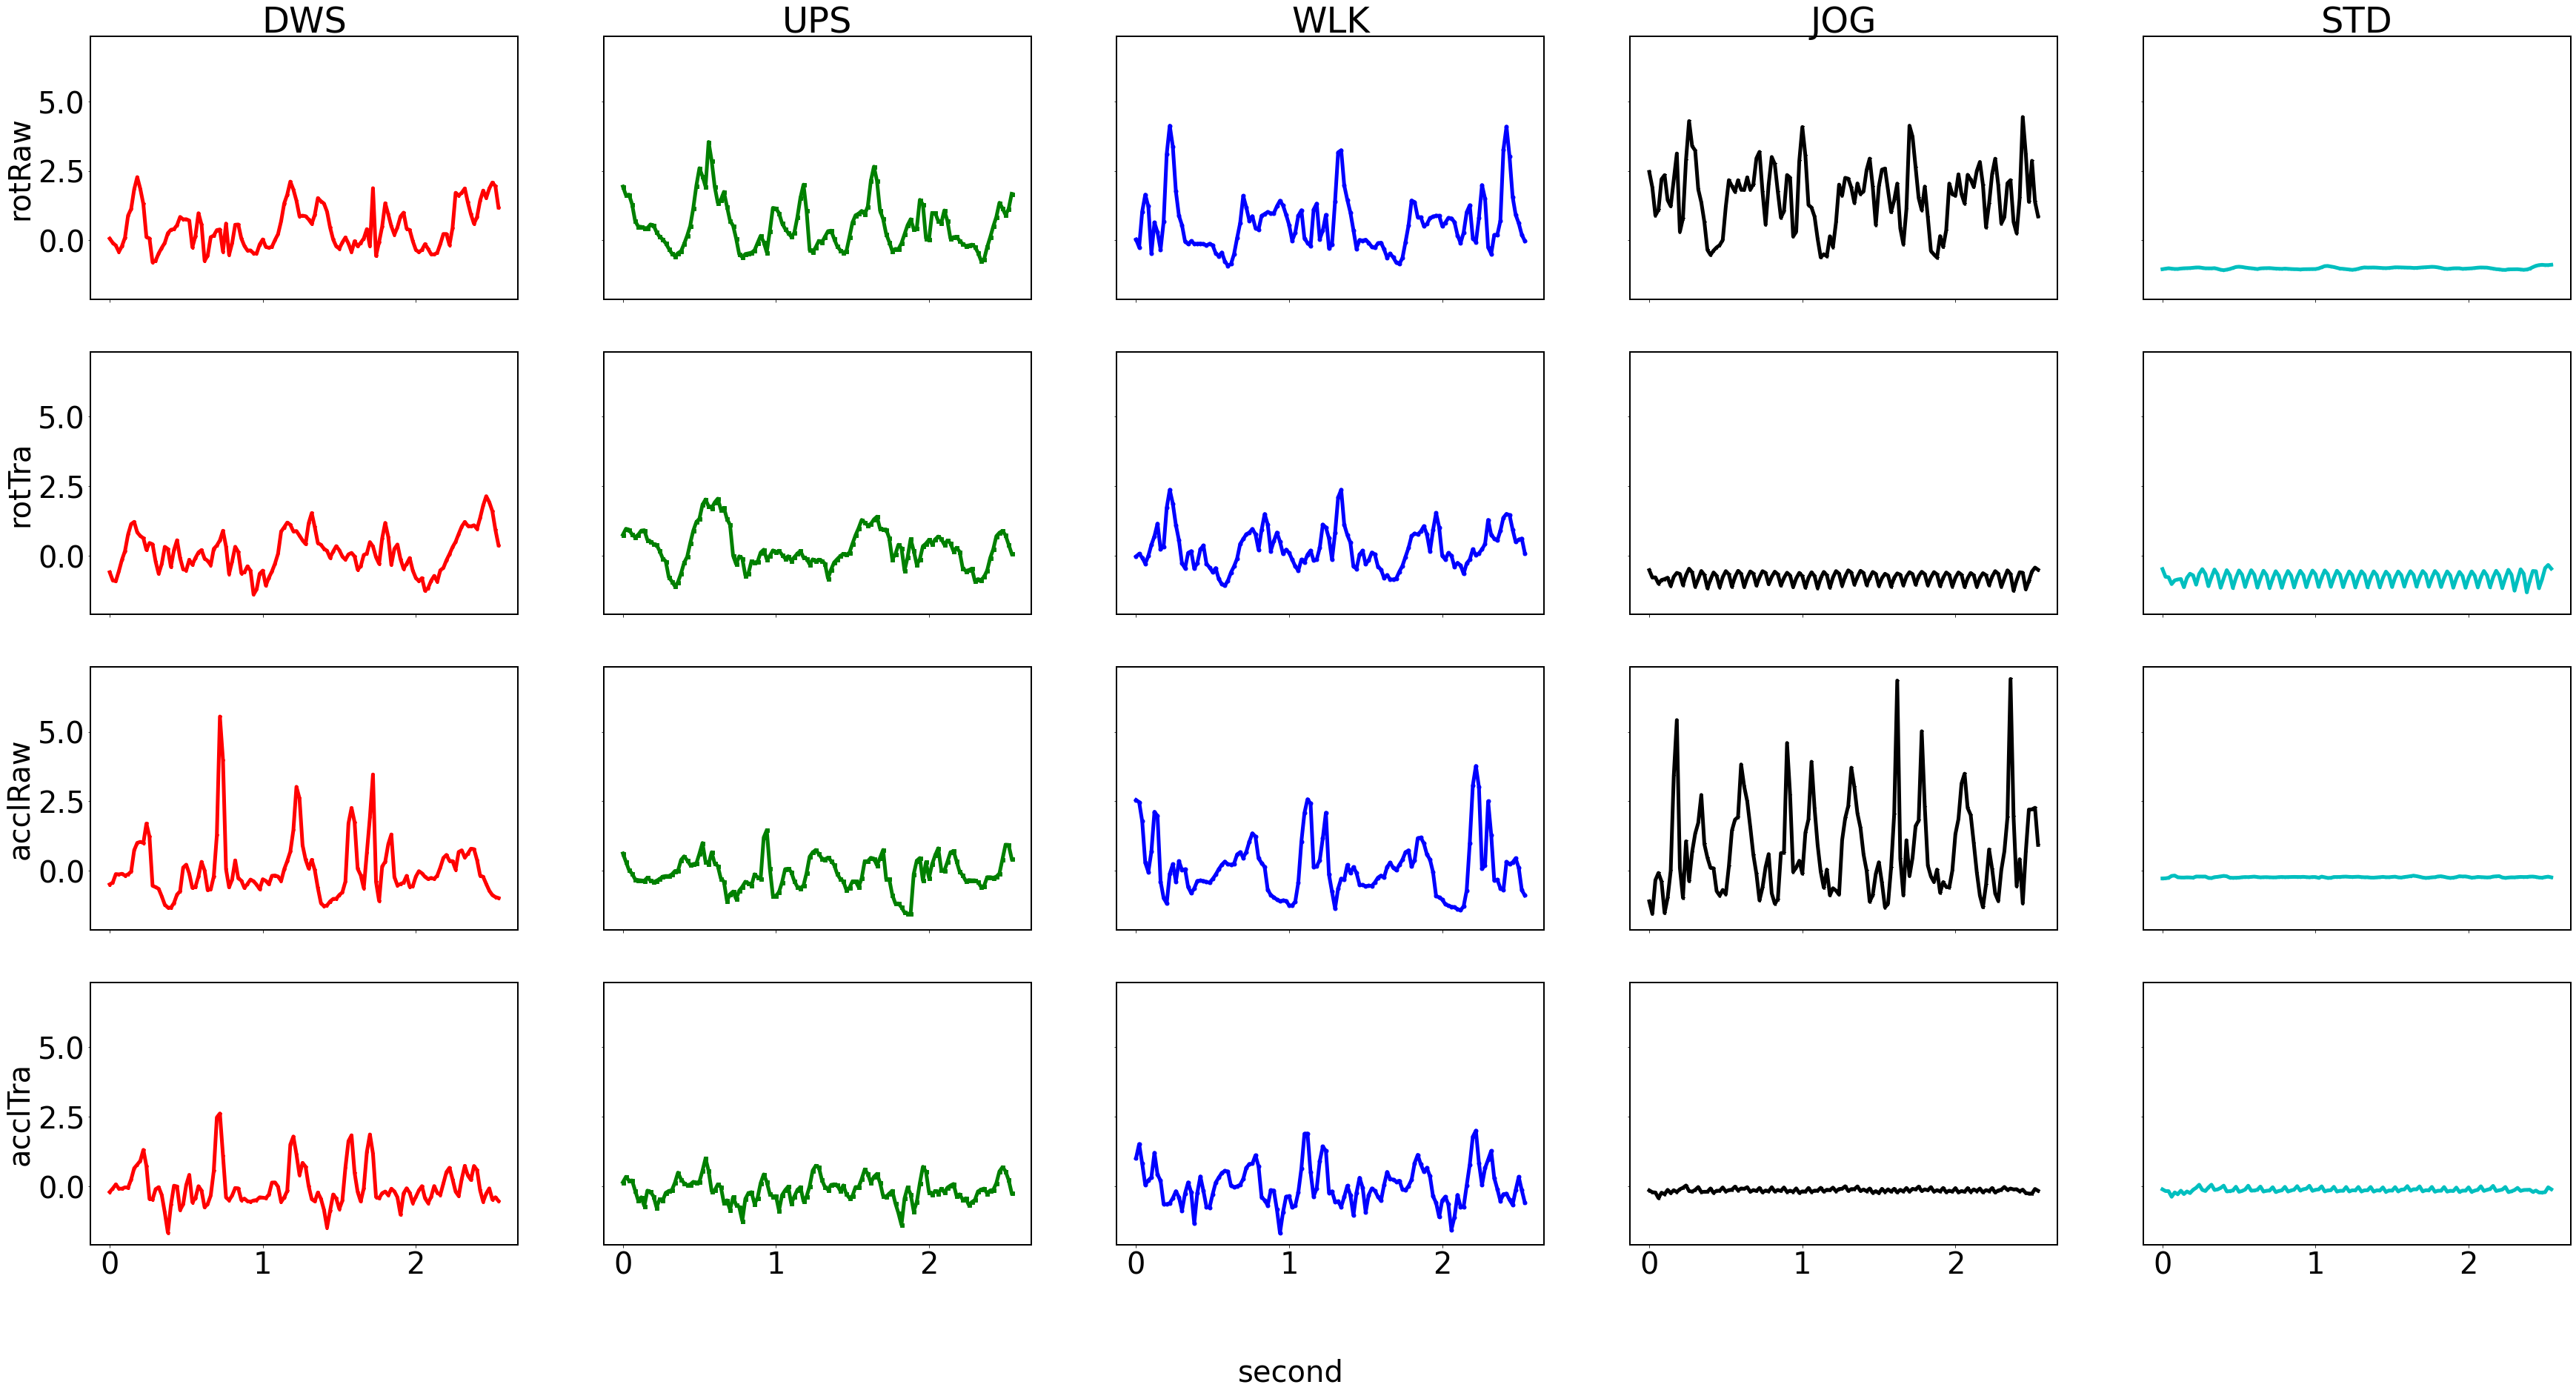

In [141]:
#rnd_smpl= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl))
plot_signals(rnd_smpl, pts, test_data, rep_anon_test)